In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import resample
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from datetime import datetime

In [8]:
df_store = pd.read_csv('../Data/store.csv')
df_train = pd.read_csv('../Data/train.csv')
df_test = pd.read_csv('../Data/test.csv')

C:\Users\Abdulaziz\AppData\Local\Temp\ipykernel_8740\769350165.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv('../Data/train.csv')


In [9]:
# Convert date columns to datetime
df_train['Date'] = pd.to_datetime(df_train['Date'])
df_test['Date'] = pd.to_datetime(df_test['Date'])

# Encode categorical columns in df_store
label_encoders = {}
for column in df_store.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df_store[column] = le.fit_transform(df_store[column].astype(str))
    label_encoders[column] = le

# Handle NaN values in df_store
df_store.fillna(0, inplace=True)

# Merge store information with train and test data
df_train = df_train.merge(df_store, on='Store', how='left')
df_test = df_test.merge(df_store, on='Store', how='left')

# Convert remaining categorical columns in df_train and df_test
categorical_columns = df_train.select_dtypes(include=['object']).columns
for column in categorical_columns:
    le = LabelEncoder()
    df_train[column] = le.fit_transform(df_train[column].astype(str))
    df_test[column] = le.transform(df_test[column].astype(str))

# Extract new features from Date
def extract_date_features(df):
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week
    df['DayOfYear'] = df['Date'].dt.dayofyear
    df['IsWeekend'] = df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)
    df['IsBeginningOfMonth'] = df['Day'].apply(lambda x: 1 if x <= 10 else 0)
    df['IsMidMonth'] = df['Day'].apply(lambda x: 1 if 10 < x <= 20 else 0)
    df['IsEndOfMonth'] = df['Day'].apply(lambda x: 1 if x > 20 else 0)
    return df

df_train = extract_date_features(df_train)
df_test = extract_date_features(df_test)

# Define a function to calculate days to/from holidays efficiently
def calculate_holiday_proximity(df, holiday_col, chunk_size=10000):
    holiday_dates = df[df[holiday_col] != 0]['Date'].unique()

    if len(holiday_dates) == 0:
        df['DaysToHoliday'] = 0
        df['DaysAfterHoliday'] = 0
        return df

    holiday_dates = np.array(holiday_dates)

    # Initialize result columns
    df['DaysToHoliday'] = np.nan
    df['DaysAfterHoliday'] = np.nan

    for start in range(0, len(df), chunk_size):
        end = min(start + chunk_size, len(df))
        chunk_dates = df['Date'].values[start:end]

        days_to_holiday = np.min(np.abs(holiday_dates[:, None] - chunk_dates), axis=0)
        days_after_holiday = np.min(np.abs(chunk_dates[:, None] - holiday_dates), axis=1)
        
        df.loc[start:end-1, 'DaysToHoliday'] = days_to_holiday
        df.loc[start:end-1, 'DaysAfterHoliday'] = days_after_holiday

    # Replace inf values with a large number (e.g., 365)
    df['DaysToHoliday'].replace(np.inf, 365, inplace=True)
    df['DaysAfterHoliday'].replace(np.inf, 365, inplace=True)

    return df

# Apply holiday proximity features in chunks
df_train = calculate_holiday_proximity(df_train, 'StateHoliday', chunk_size=10000)
df_test = calculate_holiday_proximity(df_test, 'StateHoliday', chunk_size=10000)

# Drop the 'Date' column only after all features are extracted
df_train.drop(columns=['Date'], inplace=True)
df_test.drop(columns=['Date'], inplace=True)

# Fill remaining NaNs if any
df_train.fillna(0, inplace=True)
df_test.fillna(0, inplace=True)

# Scale the data
scaler = StandardScaler()
scaled_columns = df_train.columns.difference(['Sales', 'Customers'])
df_train[scaled_columns] = scaler.fit_transform(df_train[scaled_columns])
df_test[scaled_columns] = scaler.transform(df_test[scaled_columns])

# The processed data is now ready for modeling
print(df_train.head(), df_test.head())


C:\Users\Abdulaziz\AppData\Local\Temp\ipykernel_8740\2898085045.py:64: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4924800000000000 4924800000000000 4924800000000000 ... 4233600000000000
 4233600000000000 4233600000000000]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[start:end-1, 'DaysToHoliday'] = days_to_holiday
C:\Users\Abdulaziz\AppData\Local\Temp\ipykernel_8740\2898085045.py:65: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4924800000000000 4924800000000000 4924800000000000 ... 4233600000000000
 4233600000000000 4233600000000000]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[start:end-1, 'DaysAfterHoliday'] = days_after_holiday
C:\Users\Abdulaziz\AppData\Local\Temp\ipykernel_8740\2898085045.py:68: FutureWarni

      Store  DayOfWeek  Sales  Customers      Open     Promo  StateHoliday  \
0 -1.731640   0.501484   5263        555  0.452399  1.273237     -0.159217   
1 -1.728534   0.501484   6064        625  0.452399  1.273237     -0.159217   
2 -1.725427   0.501484   8314        821  0.452399  1.273237     -0.159217   
3 -1.722321   0.501484  13995       1498  0.452399  1.273237     -0.159217   
4 -1.719214   0.501484   4822        559  0.452399  1.273237     -0.159217   

   SchoolHoliday  StoreType  Assortment  ...     Month       Day  WeekOfYear  \
0       2.144211   0.580451   -0.940975  ...  0.346724  1.740766    0.511626   
1       2.144211  -0.884348   -0.940975  ...  0.346724  1.740766    0.511626   
2       2.144211  -0.884348   -0.940975  ...  0.346724  1.740766    0.511626   
3       2.144211   0.580451    1.071502  ...  0.346724  1.740766    0.511626   
4       2.144211  -0.884348   -0.940975  ...  0.346724  1.740766    0.511626   

   DayOfYear  IsWeekend  IsBeginningOfMonth  IsMid

In [16]:
df_train.to_csv("train.csv", index=False)

In [15]:
df_test.to_csv('test.csv', index=False)

In [17]:
from statsmodels.tsa.stattools import adfuller

In [18]:
def check_stationarity(timeseries):
    # Rolling statistics
    rolmean = timeseries.rolling(window=30).mean()
    rolstd = timeseries.rolling(window=30).std()

    # Plot rolling statistics
    plt.figure(figsize=(12, 6))
    plt.plot(timeseries, label='Original')
    plt.plot(rolmean, label='Rolling Mean')
    plt.plot(rolstd, label='Rolling Std')
    plt.title('Rolling Mean & Standard Deviation')
    plt.legend()
    plt.show()

    # Perform Dickey-Fuller test
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [20]:
df_store = pd.read_csv('../Data/store.csv')
df_train = pd.read_csv('../Data/train.csv')
df_test = pd.read_csv('../Data/test.csv')

C:\Users\Abdulaziz\AppData\Local\Temp\ipykernel_8740\769350165.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv('../Data/train.csv')


In [21]:
# Merge store information with train data
df_train = pd.merge(df_train, df_store, on='Store')

# Convert Date column to datetime type and set as index
df_train['Date'] = pd.to_datetime(df_train['Date'])
df_train.set_index('Date', inplace=True)

# Extract sales data for one store as an example (you can loop through stores if needed)
store_id = 1
df_store_sales = df_train[df_train['Store'] == store_id]['Sales'].resample('D').sum()

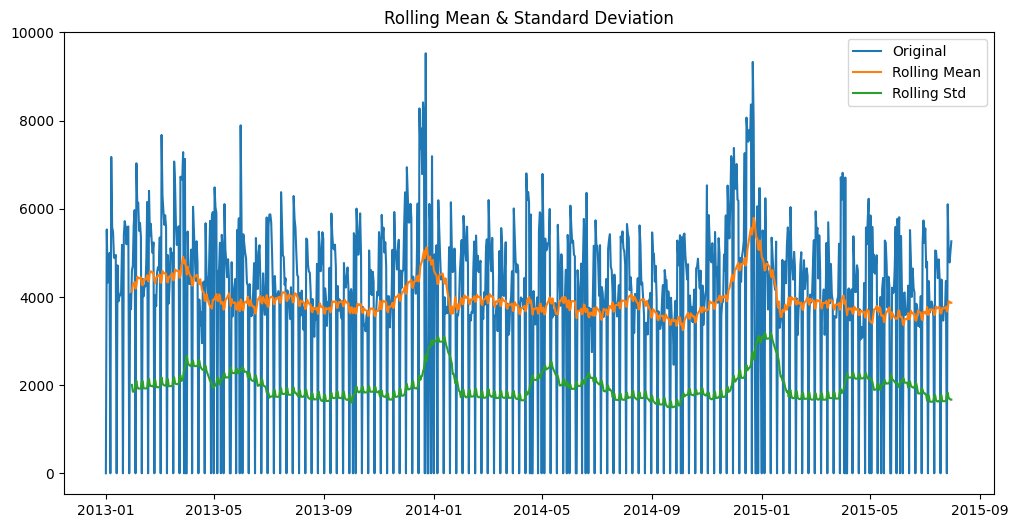

Results of Dickey-Fuller Test:
Test Statistic                  -4.368104
p-value                          0.000338
#Lags Used                      21.000000
Number of Observations Used    920.000000
Critical Value (1%)             -3.437478
Critical Value (5%)             -2.864687
Critical Value (10%)            -2.568445
dtype: float64


In [22]:
check_stationarity(df_store_sales)